# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction-to" data-toc-modified-id="Introduction-to-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction to</a></div><div class="lev2 toc-item"><a href="#What's-Julia?" data-toc-modified-id="What's-Julia?-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>What's Julia?</a></div><div class="lev2 toc-item"><a href="#R-is-great,-but..." data-toc-modified-id="R-is-great,-but...-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>R is great, but...</a></div><div class="lev2 toc-item"><a href="#Gibbs-sampler-example-by-Doug-Bates" data-toc-modified-id="Gibbs-sampler-example-by-Doug-Bates-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Gibbs sampler example by Doug Bates</a></div><div class="lev2 toc-item"><a href="#Julia-REPL-(Read-Evaluation-Print-Loop)" data-toc-modified-id="Julia-REPL-(Read-Evaluation-Print-Loop)-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Julia REPL (Read-Evaluation-Print-Loop)</a></div><div class="lev2 toc-item"><a href="#Which-Editor/IDE?" data-toc-modified-id="Which-Editor/IDE?-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Which Editor/IDE?</a></div><div class="lev2 toc-item"><a href="#Julia-package-system" data-toc-modified-id="Julia-package-system-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Julia package system</a></div><div class="lev2 toc-item"><a href="#Calling-R-from-Julia" data-toc-modified-id="Calling-R-from-Julia-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Calling R from Julia</a></div><div class="lev2 toc-item"><a href="#Some-basic-Julia-code" data-toc-modified-id="Some-basic-Julia-code-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Some basic Julia code</a></div><div class="lev2 toc-item"><a href="#Random-numbers" data-toc-modified-id="Random-numbers-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Random numbers</a></div><div class="lev2 toc-item"><a href="#Timing-and-benchmark" data-toc-modified-id="Timing-and-benchmark-110"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Timing and benchmark</a></div><div class="lev3 toc-item"><a href="#Julia" data-toc-modified-id="Julia-1101"><span class="toc-item-num">1.10.1&nbsp;&nbsp;</span>Julia</a></div><div class="lev3 toc-item"><a href="#R" data-toc-modified-id="R-1102"><span class="toc-item-num">1.10.2&nbsp;&nbsp;</span>R</a></div><div class="lev3 toc-item"><a href="#C" data-toc-modified-id="C-1103"><span class="toc-item-num">1.10.3&nbsp;&nbsp;</span>C</a></div><div class="lev3 toc-item"><a href="#Python,-builtin-sum" data-toc-modified-id="Python,-builtin-sum-1104"><span class="toc-item-num">1.10.4&nbsp;&nbsp;</span>Python, builtin <code>sum</code></a></div><div class="lev3 toc-item"><a href="#Python,-numpy" data-toc-modified-id="Python,-numpy-1105"><span class="toc-item-num">1.10.5&nbsp;&nbsp;</span>Python, numpy</a></div><div class="lev3 toc-item"><a href="#Python,-handwritten" data-toc-modified-id="Python,-handwritten-1106"><span class="toc-item-num">1.10.6&nbsp;&nbsp;</span>Python, handwritten</a></div>

# Introduction to

<img src="./julia_logo.png" alt="Julia toolchain" style="width: 400px;"/>

In [1]:
# machine information
versioninfo()

Julia Version 0.6.4
Commit 9d11f62bcb (2018-07-09 19:09 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=16)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


## What's Julia?

> Julia is a high-level, high-performance dynamic programming language for technical computing, with syntax that is familiar to users of other technical computing environments

* Started in 2009. First public release in 2012. 
  - Creators: Jeff Bezanson, Alan Edelman, Stefan Karpinski, Viral Shah
  - Current release v0.6.4
  - v1.0 is staged to release in 2018

* Aim to solve the notorious **two language problem**:
    - Prototype code goes into high-level languages like R/Python, production code goes into low-level language like C/C++
> Walks like Python. Runs like C.

* Write high-level, abstract code that closely resembles mathematical formulas
    - yet produces fast, low-level machine code that has traditionally only been generated by static languages.
    
<img src="./julia_vs_otherlang.png" align="center" width="600"/>    

* Julia is more than just "Fast R" or "Fast Matlab"
    - Performance comes from features that work well together.  
    - You can't just take the magic dust that makes Julia fast and sprinkle it on [language of choice]

## R is great, but...

* It's not meant for high performance computing
  - http://adv-r.had.co.nz/Performance.html
    - Section on performance starts with "Why is R slow?" 

* Deficiencies in the core language 
  - Many fixed with packages (`devtools`, `roxygen2`, `Matrix`, `tidyverse`)
  - Others harder to fix (R uses an old version of BLAS)
  - Some impossible to fix (clunky syntax, poor design choices)

* Only 6 active developers left (out of 20 R-Core members)
  - JuliaLang organization has 74 members, with 567 total contributors (as of 3/3/17)
    - https://github.com/JuliaLang/julia/graphs/contributors

* Doug Bates (member of R-Core, `Matrix` and `lme4`)
    - Getting Doug on board was a big win for statistics with Julia, as he brought a lot of knowledge about the history of R development and design choices
    
    > As some of you may know, I have had a (rather late) mid-life crisis and run off with another language called Julia.   
    >
    > -- <cite>Doug Bates (on the `knitr` Google Group)</cite>

## Gibbs sampler example by Doug Bates

* An example from Dr. Doug Bates's slides [Julia for R Programmers](http://www.stat.wisc.edu/~bates/JuliaForRProgrammers.pdf).

* The task is to create a Gibbs sampler for the density  
$$
f(x, y) = k x^2 exp(- x y^2 - y^2 + 2y - 4x), x > 0
$$
using the conditional distributions
$$
\begin{eqnarray*}
  X | Y &\sim& \Gamma \left( 3, \frac{1}{y^2 + 4} \right) \\
  Y | X &\sim& N \left(\frac{1}{1+x}, \frac{1}{2(1+x)} \right).
\end{eqnarray*}
$$

* **R solution**. The `RCall.jl` package allows us to execute R code without leaving the `Julia` environment. We first define an R function `Rgibbs()`.

In [2]:
# Pkg.add("RCall")
using RCall

R"""
library(Matrix)
Rgibbs <- function(N, thin) {
  mat <- matrix(0, nrow=N, ncol=2)
  x <- y <- 0
  for (i in 1:N) {
    for (j in 1:thin) {
      x <- rgamma(1, 3, y * y + 4) # 3rd arg is rate
      y <- rnorm(1, 1 / (x + 1), 1 / sqrt(2 * (x + 1)))
    }
    mat[i,] <- c(x, y)
  }
  mat
}
"""

RCall.RObject{RCall.ClosSxp}
function (N, thin) 
{
    mat <- matrix(0, nrow = N, ncol = 2)
    x <- y <- 0
    for (i in 1:N) {
        for (j in 1:thin) {
            x <- rgamma(1, 3, y * y + 4)
            y <- rnorm(1, 1/(x + 1), 1/sqrt(2 * (x + 1)))
        }
        mat[i, ] <- c(x, y)
    }
    mat
}


and then generate a sample of size 10,000 with a thinning of 500

In [3]:
R"""
Rgibbs(100, 5); # warm-up
system.time(Rgibbs(10000, 500))
"""

RCall.RObject{RCall.RealSxp}
   user  system elapsed 
 20.824   3.527  24.428 


* **Julia solution**. This is a Julia function for the same Gibbs sampler:

In [4]:
using Distributions

function jgibbs(N, thin)
    mat = zeros(N, 2)
    x = y = 0.0
    for i in 1:N
        for j in 1:thin
            x = rand(Gamma(3, 1 / (y * y + 4)))
            y = rand(Normal(1 / (x + 1), 1 / sqrt(2(x + 1))))
        end
        mat[i, 1] = x
        mat[i, 2] = y
    end
    mat
end

jgibbs (generic function with 1 method)

Generate the same sample. How long does it take?

In [5]:
jgibbs(100, 5); # warm-up
@elapsed jgibbs(10000, 500)

0.356441601

We see ~50 fold speed up of `Julia` over `R` on this example, **without extra coding effort**!

## Julia REPL (Read-Evaluation-Print-Loop)

The `Julia` REPL, or `Julia` shell, has four main modes.

0. **Default mode** is the Julian prompt `julia>`. Type backspace in other modes to enter default mode.    

0. **Help mode** `help?>`. Type `?` to enter help mode. `?search_term` does a fuzzy search for `search_term`. 

0. **Shell mode** `shell>`. Type `;` to enter shell mode.  

0. **Search mode** `(reverse-i-search)`. Press `ctrl+R` to enter search model. 

0. With `RCall.jl` package installed, we can enter the **R mode** by typing `$` (shift+4) at Julia REPL.

Some survival commands in Julia REPL:  
0. `quit()` or `Ctrl+D`: exit Julia.

0. `Ctrl+C`: interrupt execution.

0. `Ctrl+L`: clear screen.

0. `whos()`: list all variables in current workspace.

0. `workspace()`: clear all variables and reset session.

0. Append `;` (semi-colon) to suppress displaying output from a command.

0. `include("filename.jl")` to source a Julia code file.

0. One very useful command to display the machine information is `versioninfo()`. `versioninfo(true)` gives detailed system information.

In [6]:
versioninfo()

Julia Version 0.6.4
Commit 9d11f62bcb (2018-07-09 19:09 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=16)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


## Which Editor/IDE?

* I highly recommend  
    * Editor [Visual Studio Code](https://code.visualstudio.com) with the Julia extension installed, or  
    * Editor [Atom](https://atom.io) with packages `julia-client`, `language-julia`, and `latex-completions` installed. 

* If you want RStudio- or Matlab-like IDE, you can try 
    * [JupyterLab](https://github.com/jupyterlab/jupyterlab), or 
    * install the `uber-juno` package in Atom. Follow instructions at [https://github.com/JunoLab/uber-juno/blob/master/setup.md](https://github.com/JunoLab/uber-juno/blob/master/setup.md).

* [**JuliaPro**](https://juliacomputing.com/products/juliapro.html) bundles Julia, Atom, Juno, and many commonly used packages. It has an option to use Intel MKL (Mathematical Kernel Library) instead of OpenBLAS for linear algebra.

## Julia package system

<img src="http://pkg.julialang.org/img/allver.svg" width="500" align="center"/>

* Each Julia package is a Git repository. Each Julia package name ends with `.jl`. E.g., `Distributions.jl` package lives at <https://github.com/JuliaStats/Distributions.jl>.   
Google search with `PackageName.jl` usually leads to the package on github.com. 

* The package ecosystem is rapidly maturing; a complete list of **registered** packages (which are required to have a certain level of testing and documentation) is at [http://pkg.julialang.org/](http://pkg.julialang.org/).

* For example, the package called `Distributions.jl` is added with
```julia
Pkg.add("Distributions")   # no .jl 
```
and "removed" (although not completely deleted) with
```julia
Pkg.rm("Distributions")
```
* The package manager provides a dependency solver that determines which packages are actually required to be installed.

* **Non-registered** packages are added by cloning the relevant Git repository. E.g.,
```julia
Pkg.clone("git@github.com:OpenMendel/SnpArrays.jl.git")
```

* A package needs only be added once, at which point it is downloaded into your local `.julia/vx.x` directory in your home directory. 

* Directory of a specific package can be queried by `Pkg.dir()`:

In [7]:
Pkg.dir("Distributions")

"/Users/huazhou/.julia/v0.6/Distributions"

* If you start having problems with packages that seem to be unsolvable, you can try just deleting your .julia directory and reinstalling all your packages. 

* For **JuliaPro**, the packages are downloaed to directory `/Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/`.

* Periodically, one should run `Pkg.update()`, which checks for, downloads and installs updated versions of all the packages you currently have installed.

* `Pkg.status()` lists the status of all installed packages.

* Using functions in package.
```julia
using Distributions
```
This pulls all of the *exported* functions in the module into your local namespace, as you can check using the `whos()` command. An alternative is
```julia
import Distributions
```
Now, the functions from the Distributions package are available only using 
```julia
Distributions.<FUNNAME>
```
All functions, not only exported functions, are always available like this.

## Calling R from Julia

* The [`RCall.jl`](https://github.com/JuliaInterop/RCall.jl) package allows you to embed R code inside of Julia. Internally it calls the R installed on the same computer.

* For other languages, check [JuliaInterop](https://github.com/JuliaInterop): `PyCall`, `MATLAB`, `JavaCall`, `CxxWrap`, ... 

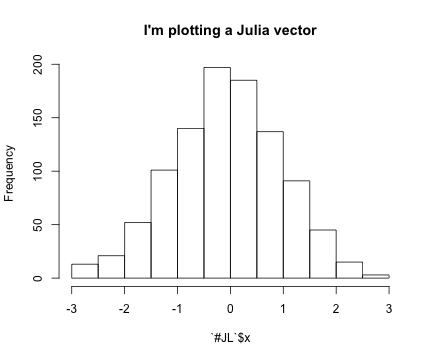

RCall.RObject{RCall.VecSxp}
$breaks
 [1] -3.0 -2.5 -2.0 -1.5 -1.0 -0.5  0.0  0.5  1.0  1.5  2.0  2.5  3.0

$counts
 [1]  13  21  52 101 140 197 185 137  91  45  15   3

$density
 [1] 0.026 0.042 0.104 0.202 0.280 0.394 0.370 0.274 0.182 0.090 0.030 0.006

$mids
 [1] -2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75  2.25  2.75

$xname
[1] "`#JL`$x"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


In [8]:
# Pkg.add("RCall")
using RCall

# Julia vector x is interpolated into R workspace
x = randn(1000)
R"""
hist($x, main="I'm plotting a Julia vector")
"""

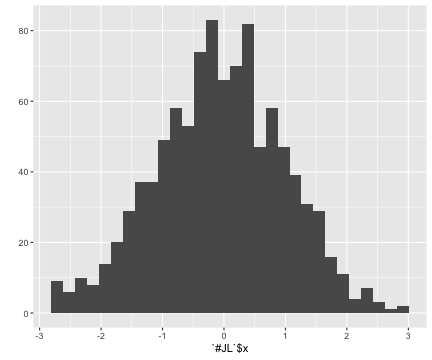

RCall.RObject{RCall.VecSxp}


In [9]:
R"""
library(ggplot2)
qplot($x)
"""

In [10]:
# wrapper of R variable(s)
x = R"""
rnorm(10)
"""

RCall.RObject{RCall.RealSxp}
 [1]  0.84112708 -0.31987073  0.01606729 -2.38312612 -1.95506213  0.59494239
 [7] -0.85099823 -0.60422724  0.40716350  1.10809499


In [11]:
# convert it into Julia variable
y = collect(x)

10-element Array{Float64,1}:
  0.841127 
 -0.319871 
  0.0160673
 -2.38313  
 -1.95506  
  0.594942 
 -0.850998 
 -0.604227 
  0.407164 
  1.10809  

* Access Julia variables in R REPL mode:
```julia
julia> x = rand(5) # Julia variable
R> y <- $x
```

* Pass Julia expression in R REPL mode:
```julia
R> y <- $(rand(5))
```

* Put Julia variable into R environment:
```julia
julia> @rput x
R> x
```

* Get R variable into Julia environment:
```julia
R> r <- 2
Julia> @rget r
```

* If you want to call Julia within R, check out the [`XRJulia`](https://cran.r-project.org/web/packages/XRJulia/) package by John Chambers.

## Some basic Julia code

In [12]:
y = 1
typeof(y) # same as int in R

Int64

In [13]:
y = 1.0
typeof(y) # same as double in R

Float64

In [14]:
# Greek letters:  `\pi<tab>`
π

π = 3.1415926535897...

In [15]:
# Greek letters:  `\theta<tab>`
θ = y + π

4.141592653589793

In [16]:
# emoji! `\:kissing_cat:<tab>`
😽 = 5.0

5.0

In [17]:
# wear a hat: `\alpha<tab>\hat<tab>`
α̂ = π

π = 3.1415926535897...

In [18]:
# vector of Float64 0s
x = zeros(5)

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [19]:
# vector of Int64 0s
x = zeros(Int, 5)

5-element Array{Int64,1}:
 0
 0
 0
 0
 0

In [20]:
# matrix of Float64 0s
x = zeros(5, 3)

5×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [21]:
# matrix of Float64 1s
x = ones(5, 3)

5×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [22]:
# define array without initialization
x = Array{Float64}(5, 3)

5×3 Array{Float64,2}:
 0.0           0.0           0.0         
 0.0           0.0           2.23563e-314
 0.0           0.0           0.0         
 2.37723e-314  2.37275e-314  2.37283e-314
 0.0           2.38477e-314  0.0         

In [23]:
# fill an array by 0s
fill!(x, 0)

5×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [24]:
# initialize an array to be 2.5
fill(2.5, (5, 3))

5×3 Array{Float64,2}:
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5

In [25]:
a = 3//5

3//5

In [26]:
typeof(a)

Rational{Int64}

In [27]:
b = 3//7
a + b

36//35

## Random numbers

In [28]:
# set random seed
srand(2018)

MersenneTwister(UInt32[0x000007e2], Base.dSFMT.DSFMT_state(Int32[-202096972, 1073008071, 2126042476, 1072793678, -64266256, 1072791560, -862800465, 1073689841, -1825118558, 1073580158  …  1117634044, 1073654874, -1803952621, 1073214982, 870324007, 762330074, 800503355, 556564238, 382, 0]), [1.13398, 1.47522, 1.32981, 1.12859, 1.39857, 1.86132, 1.51023, 1.84741, 1.92563, 1.35764  …  1.46187, 1.07599, 1.10617, 1.43957, 1.37192, 1.75769, 1.33281, 1.65283, 1.43196, 1.15743], 382)

In [29]:
# uniform [0, 1) random numbers
x = rand(5, 3)

5×3 Array{Float64,2}:
 0.654539  0.682842  0.356495
 0.108906  0.151455  0.260692
 0.723586  0.612651  0.970956
 0.720367  0.982534  0.966637
 0.262428  0.75867   0.34616 

In [30]:
# uniform random numbers (in single precision)
x = rand(Float32, 5, 3)

5×3 Array{Float32,2}:
 0.608769  0.725878   0.0518984
 0.771825  0.165383   0.9217   
 0.185688  0.295632   0.260074 
 0.243404  0.538624   0.861518 
 0.196947  0.0133095  0.753027 

In [31]:
# random numbers from {1,...,5}
x = rand(1:5, 5, 3)

5×3 Array{Int64,2}:
 5  2  1
 5  1  4
 3  2  2
 5  3  2
 3  5  1

In [32]:
# standard normal random numbers
x = randn(5, 3)

5×3 Array{Float64,2}:
  0.56144     0.403827  -0.133275 
  0.0981954  -0.665607   0.0685784
  0.588447    1.01008    0.854076 
 -0.112509    0.898838  -0.837714 
 -0.120294    1.49929    0.27118  

To generate random samples from a specific distribution, we use the Distributions.jl package.

In [33]:
using Distributions

# iid Exp(1)
rand(Exponential(1), 5, 3)

5×3 Array{Float64,2}:
 0.585735    2.24753   0.794098 
 0.906154    1.37461   3.32346  
 0.311748    2.36775   0.147374 
 0.0436434   0.919539  0.446208 
 0.00157463  0.172398  0.0778576

## Timing and benchmark

`@time`, `@elapsed`, `@allocated` macros:

In [34]:
srand(123) # seed
x = randn(10^7)
@time sum(x) # first run includes compilation time
@time sum(x) # no compilation time after first run

-3272.922691520938

  0.035734 seconds (9.88 k allocations: 545.223 KiB)
  0.004045 seconds (5 allocations: 176 bytes)


In [35]:
@elapsed sum(x)

0.006489112

In [36]:
@allocated sum(x)

16

###  Julia

Use `BenchmarkTools.jl` for more robust benchmarking. Analog to `microbenchmark` package in R.

In [37]:
using BenchmarkTools

@benchmark sum($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.720 ms (0.00% GC)
  median time:      4.793 ms (0.00% GC)
  mean time:        4.907 ms (0.00% GC)
  maximum time:     6.589 ms (0.00% GC)
  --------------
  samples:          1018
  evals/sample:     1

### R

In [38]:
using RCall

R"""
library(microbenchmark)
microbenchmark(sum($x))
"""

RCall.RObject{RCall.VecSxp}
Unit: milliseconds
         expr      min       lq     mean   median       uq      max neval
 sum(`#JL`$x) 8.650309 8.900707 9.226273 9.036881 9.383665 11.48902   100


Why is R ~1.5-2 fold slower than Julia?

### C

In [39]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [40]:
@benchmark c_sum($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.080 ms (0.00% GC)
  median time:      11.703 ms (0.00% GC)
  mean time:        11.810 ms (0.00% GC)
  maximum time:     15.473 ms (0.00% GC)
  --------------
  samples:          424
  evals/sample:     1

### Python, builtin `sum`

In [41]:
using PyCall
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")
@benchmark $pysum($x)

BenchmarkTools.Trial: 
  memory estimate:  152.60 MiB
  allocs estimate:  10000068
  --------------
  minimum time:     1.633 s (26.07% GC)
  median time:      1.762 s (28.22% GC)
  mean time:        1.721 s (27.62% GC)
  maximum time:     1.768 s (28.12% GC)
  --------------
  samples:          3
  evals/sample:     1

### Python, numpy

In [42]:
using Conda

numpy_sum = pyimport("numpy")["sum"]

@benchmark $numpy_sum($x)

LoadError: [91mPyError (PyImport_ImportModule

The Python package numpy could not be found by pyimport. Usually this means
that you did not install numpy in the Python version being used by PyCall.

PyCall is currently configured to use the Julia-specific Python distribution
installed by the Conda.jl package.  To install the numpy module, you can
use `pyimport_conda("numpy", PKG)`, where PKG is the Anaconda
package the contains the module numpy, or alternatively you can use the
Conda package directly (via `using Conda` followed by `Conda.add` etcetera).

Alternatively, if you want to use a different Python distribution on your
system, such as a system-wide Python (as opposed to the Julia-specific Python),
you can re-configure PyCall with that Python.   As explained in the PyCall
documentation, set ENV["PYTHON"] to the path/name of the python executable
you want to use, run Pkg.build("PyCall"), and re-launch Julia.

) <type 'exceptions.ImportError'>
ImportError('cannot import name add_newdocs',)
  File "/Users/huazhou/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/numpy/__init__.py", line 142, in <module>
    from . import add_newdocs
[39m

### Python, handwritten

In [43]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

@benchmark $sum_py($x)

BenchmarkTools.Trial: 
  memory estimate:  152.60 MiB
  allocs estimate:  10000068
  --------------
  minimum time:     2.013 s (21.44% GC)
  median time:      2.088 s (23.70% GC)
  mean time:        2.071 s (23.00% GC)
  maximum time:     2.112 s (23.80% GC)
  --------------
  samples:          3
  evals/sample:     1